### Benjamin-Ousmane M'BENGUE

In [1]:
import gc
import torch

from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, smape, mae

from darts.models import (
    TransformerModel,
    NBEATSModel,
)

# Use of GPU
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

c:\Users\ousma\miniconda3\envs\streamlit-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Norm generation

Check https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb for more explanations

## 1.1 Data preparation

In [2]:
# load data
df1 = pd.read_json("./match_1.json")
df2 = pd.read_json("./match_2.json")
df = pd.concat([df1, df2])
df.dropna()
df = df.reset_index(drop=True)
df.head(10)

,label,norm
0,walk,"[23.177037336396975, 23.361525285249378, 21.53..."
1,walk,"[20.998214383911275, 19.182798059840767, 18.27..."
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554..."
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787..."
4,rest,"[22.069263037713093, 19.672270483203395, 19.88..."
5,walk,"[19.92032356700904, 19.672270483203395, 18.688..."
6,walk,"[72.43782600710844, 29.1545534760874, 51.00451..."
7,walk,"[56.86645792611747, 24.06617147011633, 39.4051..."
8,run,"[34.587473483674074, 33.423278993730264, 21.71..."
9,run,"[10.642204698384765, 27.15560347765402, 40.427..."


In [3]:
# Truncate and padding

max_sequence_length = 128 # 3sec (=150 values) for a gait is too long --> we can go with batches of 128 values (=2.56sec)

def truncate_and_pad(sequence, max_length):
    if len(sequence) > max_length:
        return sequence[:max_length]
    else:
        padding = [0.0] * (max_length - len(sequence))
        return sequence + padding

df['norm'] = df['norm'].apply(lambda seq: truncate_and_pad(seq, max_sequence_length))

print(df["norm"][0])

[23.177037336396975, 23.361525285249378, 21.535253402993348, 23.400315476270563, 23.0075250246004, 22.92731691635618, 23.14366192455148, 22.91689096213586, 22.265133990831664, 21.444639377371956, 20.469615451761555, 21.06943270715139, 20.60931715782685, 20.277210314360328, 18.978770878117903, 20.266430140783392, 20.03970416440424, 21.535253402993348, 20.830143193730382, 20.52762482805694, 19.81910892494368, 21.43089703638041, 21.172213956523564, 19.672270483203395, 19.804895724542405, 22.07590545995683, 20.778710987569003, 22.20310769639438, 24.056427879304728, 22.57028852159386, 24.54176116174663, 27.453754394358562, 33.49535355717796, 34.30926899260859, 36.65541988850446, 40.69312434666373, 29.38785757328513, 27.53957025836676, 27.40948479957553, 25.492739904893572, 24.7869758841489, 30.41546793475928, 26.91068564305117, 20.521174778553675, 19.619578129641376, 18.03710192104068, 17.81373191482844, 19.330241184992065, 21.18926361979265, 19.87904673442728, 15.586469706355318, 15.600509

In [4]:
# Create one norm list by unique label

norms_by_label = {}

# Iterate through the DataFrame and organize norms by label
for index, row in df.iterrows():
    label = row['label']
    norm_values = row['norm']
    
    if label not in norms_by_label:
        norms_by_label[label] = []
    
    norms_by_label[label].extend(norm_values)

# Create a list of dictionaries for the DataFrame
data_list = [{'label': label, 'norm': norm_values} for label, norm_values in norms_by_label.items()]

# Create a pandas DataFrame from the list of dictionaries
grouped_df = pd.DataFrame(data_list)
print(grouped_df)

       label                                               norm
0       walk  [23.177037336396975, 23.361525285249378, 21.53...
1       rest  [22.069263037713093, 19.672270483203395, 19.88...
2        run  [34.587473483674074, 33.423278993730264, 21.71...
3     tackle  [29.034410616944584, 28.82156507329952, 31.965...
4    dribble  [28.985802058905858, 26.17263539170306, 21.234...
5       pass  [29.653541236594563, 95.4314774282106, 58.0746...
6      cross  [57.65439590486032, 111.02478206918458, 60.186...
7       shot  [35.47820704552003, 23.462783850464124, 78.264...
8  no action  [104.42423889328715, 87.63989343949717, 128.52...


In [5]:
# Create Darts series
series_list = []
scaler = Scaler()

for label, norm_list in norms_by_label.items():
    series = TimeSeries.from_values(np.array(norm_list))
    # series_list.append(series)
    
    # Normalize the time series
    series_scaled = scaler.fit_transform(series)
    series_list.append(series_scaled)

# Add the series_list to the new_df DataFrame
grouped_df['norm_series'] = series_list

grouped_df

,label,norm,norm_series
0,walk,"[23.177037336396975, 23.361525285249378, 21.53...","(((<TimeSeries (DataArray) (time: 1, component..."
1,rest,"[22.069263037713093, 19.672270483203395, 19.88...","(((<TimeSeries (DataArray) (time: 1, component..."
2,run,"[34.587473483674074, 33.423278993730264, 21.71...","(((<TimeSeries (DataArray) (time: 1, component..."
3,tackle,"[29.034410616944584, 28.82156507329952, 31.965...","(((<TimeSeries (DataArray) (time: 1, component..."
4,dribble,"[28.985802058905858, 26.17263539170306, 21.234...","(((<TimeSeries (DataArray) (time: 1, component..."
5,pass,"[29.653541236594563, 95.4314774282106, 58.0746...","(((<TimeSeries (DataArray) (time: 1, component..."
6,cross,"[57.65439590486032, 111.02478206918458, 60.186...","(((<TimeSeries (DataArray) (time: 1, component..."
7,shot,"[35.47820704552003, 23.462783850464124, 78.264...","(((<TimeSeries (DataArray) (time: 1, component..."
8,no action,"[104.42423889328715, 87.63989343949717, 128.52...","(((<TimeSeries (DataArray) (time: 1, component..."


<function matplotlib.pyplot.show(close=None, block=None)>

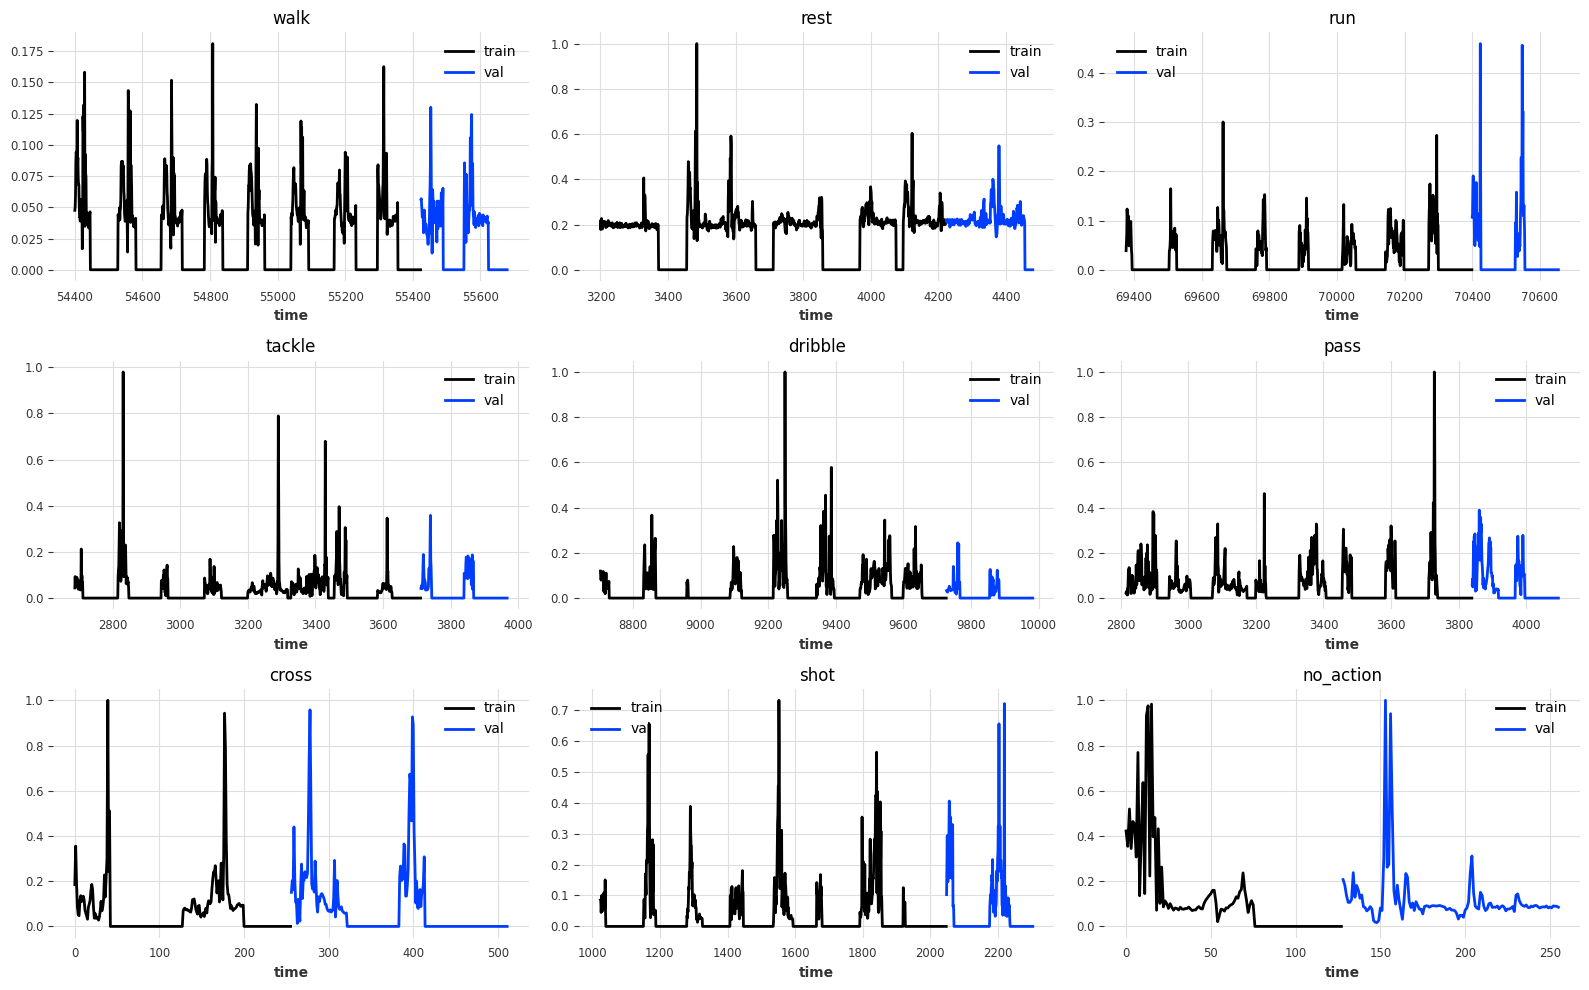

In [6]:
# Train / Validation split
# keep 1024 val max for each training set
train_walk, val_walk = grouped_df['norm_series'][0][-1280:-256], grouped_df['norm_series'][0][-256:]
train_rest, val_rest = grouped_df['norm_series'][1][-1280:-256], grouped_df['norm_series'][1][-256:]
train_run, val_run = grouped_df['norm_series'][2][-1280:-256], grouped_df['norm_series'][2][-256:]
train_tackle, val_tackle = grouped_df['norm_series'][3][-1280:-256], grouped_df['norm_series'][3][-256:]
train_dribble, val_dribble = grouped_df['norm_series'][4][-1280:-256], grouped_df['norm_series'][4][-256:]
train_pass, val_pass = grouped_df['norm_series'][5][-1280:-256], grouped_df['norm_series'][5][-256:]
train_cross, val_cross = grouped_df['norm_series'][6][-1280:-256], grouped_df['norm_series'][6][-256:]
train_shot, val_shot = grouped_df['norm_series'][7][-1280:-256], grouped_df['norm_series'][7][-256:]
train_no_action, val_no_action = grouped_df['norm_series'][8][-1280:-128], grouped_df['norm_series'][8][-128:]

train_val_datasets = {
    "walk" : [train_walk, val_walk],
    "rest" : [train_rest, val_rest],
    "run" : [train_run, val_run],
    "tackle" : [train_tackle, val_tackle],
    "dribble" : [train_dribble, val_dribble],
    "pass" : [train_pass, val_pass],
    "cross" : [train_cross, val_cross],
    "shot" : [train_shot, val_shot],
    "no_action" : [train_no_action, val_no_action]
}

# Plot each series on separate charts
fig = plt.figure(figsize=(16, 10))
i = 0
for label, dataset in train_val_datasets.items() :
    train = dataset[0]
    val = dataset[1]
    
    
    fig.add_subplot(3, 3, i+1)
    train.plot(label = "train")
    val.plot(label = "val")
    plt.title(label)
    
    i = i+1
fig.tight_layout()
plt.show


## 1.2 Models

In [7]:
norm_model = TransformerModel(
    input_chunk_length=50, #24
    output_chunk_length=20, #12
    batch_size=256, #256
    n_epochs=200, #200
    d_model=128, #128
    dim_feedforward=256, #128
    nhead=32, #8
    num_encoder_layers=4, #4
    num_decoder_layers=4, #4
    dropout=0.0001, #0.01
    activation="relu",
    nr_epochs_val_period=10, 
    # random_state=0,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

In [8]:
train_series = []

for label, dataset in train_val_datasets.items() :
    train_series.append(dataset[0])

norm_model.fit(train_series, verbose=True);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 256   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 1.3 M 
6 | decoder             | Linear              | 2.6 K 
------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
10.627    Total estimated model params size (MB)


Epoch 199: 100%|██████████| 34/34 [01:20<00:00,  2.37s/it, loss=0.00151, train_loss=0.00133] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 34/34 [01:20<00:00,  2.37s/it, loss=0.00151, train_loss=0.00133]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

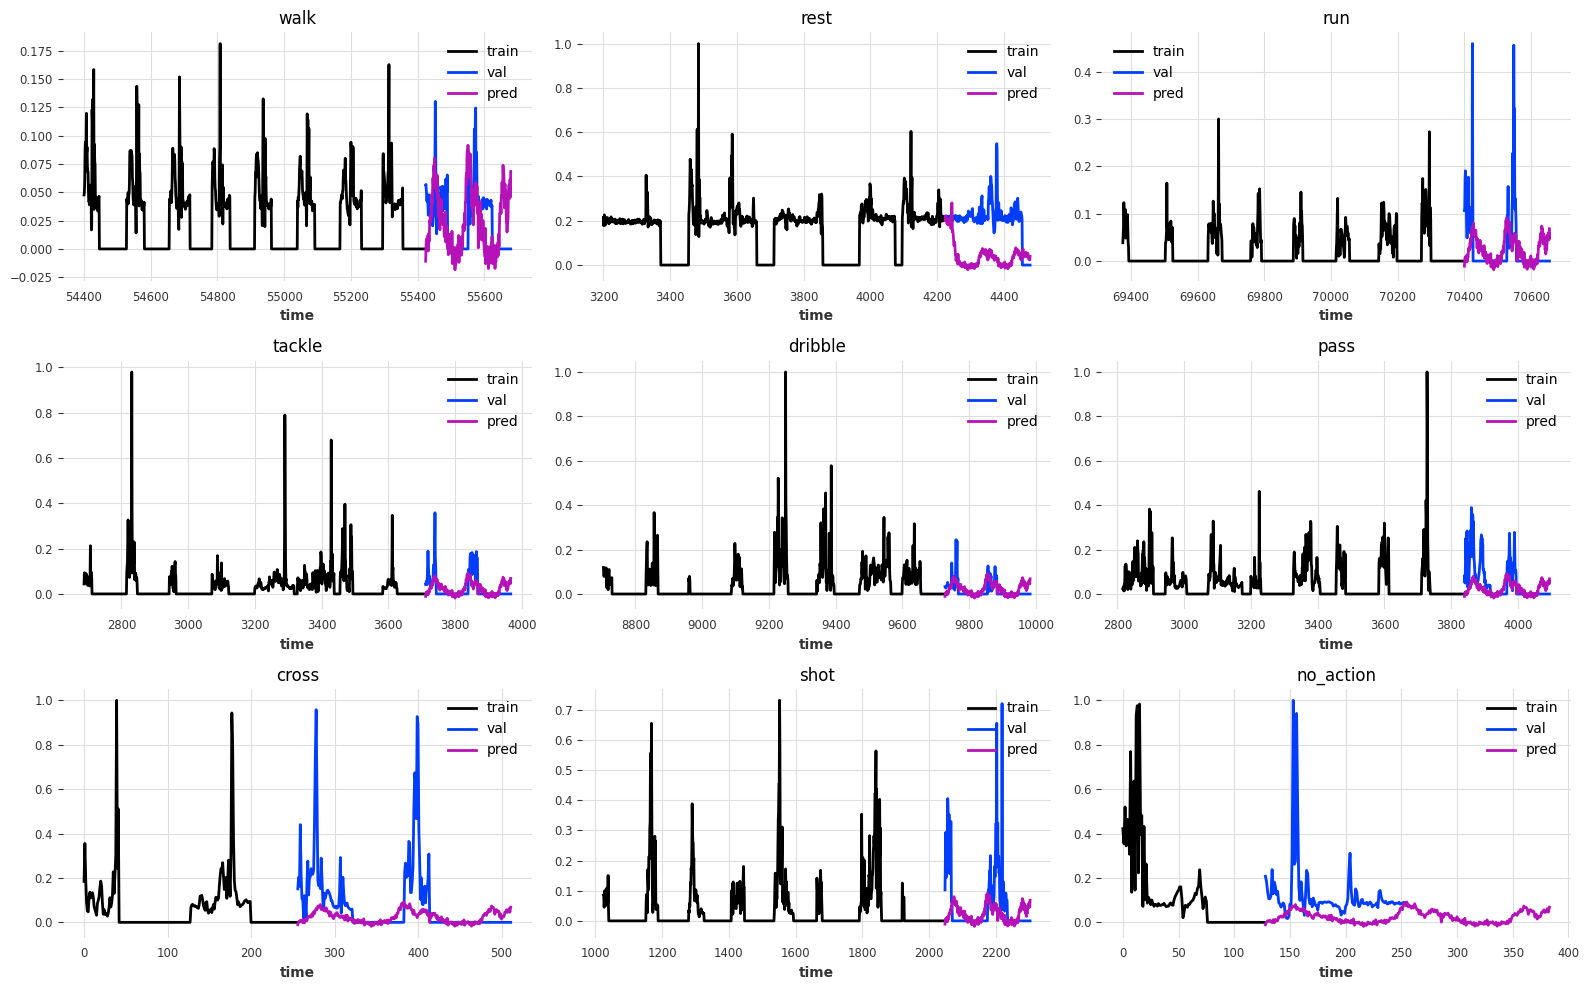

In [9]:
# Predictions 
pred_list = norm_model.predict(n=256, series=train_series)

# Plot each series on separate charts
fig = plt.figure(figsize=(16, 10))
i = 0

for label, dataset in train_val_datasets.items() :
    train = dataset[0]
    val = dataset[1]
    pred = pred_list[i]
    
    fig.add_subplot(3, 3, i+1)
    train.plot(label = "train")
    val.plot(label = "val")
    pred.plot(label = "pred")
    
    plt.title(label)
    
    i = i+1
fig.tight_layout()
plt.show

In [10]:
norm_model.save("./models/norm_model.pkl")

# 2. labels generation 

In [11]:
# Encode labels
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(df["label"])
print(len(encoded_labels))
print(encoded_labels)
print(label_encoder.classes_)

# convert in timeseries
label_series = TimeSeries.from_values(np.array(encoded_labels))

1187
[8 8 8 ... 8 8 8]
['cross' 'dribble' 'no action' 'pass' 'rest' 'run' 'shot' 'tackle' 'walk']


In [12]:
label_model = TransformerModel(
    n_epochs=500, #500
    input_chunk_length=40, #24
    output_chunk_length=15, #12
    batch_size=256, #256
    d_model=128, #128
    dim_feedforward=256, #256
    nhead=32, #32
    num_encoder_layers=1, #2
    num_decoder_layers=1, #2
    dropout=0.0001, #0.0001
    activation="relu",
    nr_epochs_val_period=10, 
    # random_state=0,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

In [13]:
label_model.fit(label_series, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 256   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 331 K 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
2.672     Total estimated model params size (MB)


Epoch 499: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s, loss=0.0689, train_loss=0.0687]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s, loss=0.0689, train_loss=0.0687]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


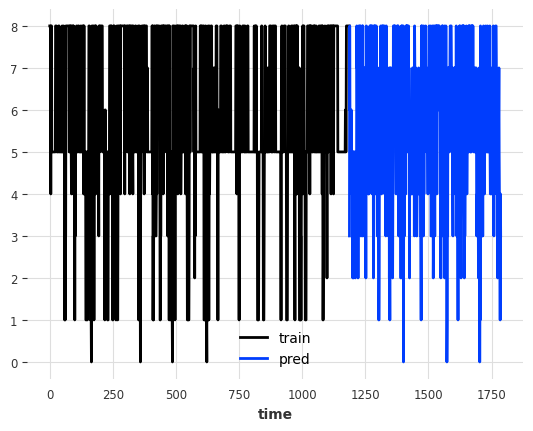

In [14]:
generated_labels = label_model.predict(n=600, series = None)

generated_labels = generated_labels.map(lambda x: np.round(x))
generated_labels = generated_labels.map(lambda x: np.clip(x, 0, 8))

label_series.plot(label = "train")
generated_labels.plot(label = "pred")

In [15]:
# Get labels back
generated_labels_decoded = label_encoder.inverse_transform(generated_labels.values().astype(int))

generated_labels_decoded

c:\Users\ousma\miniconda3\envs\streamlit-env\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['pass', 'walk', 'shot', 'shot', 'shot', 'run', 'run', 'shot',
       'run', 'run', 'rest', 'run', 'run', 'no action', 'run', 'rest',
       'no action', 'run', 'rest', 'rest', 'pass', 'run', 'pass',
       'no action', 'pass', 'pass', 'pass', 'rest', 'rest', 'walk',
       'tackle', 'tackle', 'run', 'tackle', 'no action', 'run', 'rest',
       'walk', 'rest', 'run', 'tackle', 'walk', 'tackle', 'tackle',
       'walk', 'pass', 'shot', 'tackle', 'shot', 'shot', 'pass', 'walk',
       'tackle', 'walk', 'pass', 'tackle', 'shot', 'tackle', 'tackle',
       'shot', 'rest', 'shot', 'tackle', 'tackle', 'rest', 'no action',
       'run', 'walk', 'run', 'run', 'run', 'run', 'shot', 'shot', 'shot',
       'rest', 'shot', 'rest', 'shot', 'shot', 'tackle', 'walk', 'run',
       'walk', 'walk', 'walk', 'shot', 'walk', 'tackle', 'shot', 'rest',
       'walk', 'tackle', 'run', 'tackle', 'no action', 'run', 'walk',
       'tackle', 'tackle', 'walk', 'tackle', 'walk', 'tackle', 'run',
       'res

In [16]:
label_model.save("./models/label_model.pkl")